In [64]:
# 🧪 Logistic Regression for Parasite Classification (Google Colab)
# UTS 42177 – Image Processing and Pattern Recognition
# Author: Muhib Al Muquit
# ------------------------------------------------------

# ⚙️ STEP 1 – Install dependencies
!pip install scikit-image scikit-learn matplotlib pandas tqdm seaborn


In [65]:
# 🧰 STEP 2 – Import libraries
import os, numpy as np, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from skimage import io, color, transform, feature
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import joblib


In [66]:
# 🧩 STEP 3 — Mount Google Drive and Set Dataset Path
from google.colab import drive
import os, pandas as pd

# 1️⃣ Mount your Drive
drive.mount('/content/drive')

# 2️⃣ Define your dataset path
# ⚠️ Change <YourFolderName> if your folder appears with a different name in MyDrive
DATA_BASE = "/content/drive/MyDrive/42177_Project"

# If your dataset ZIP is still inside Drive, unzip it here (optional)
# Uncomment this line if needed:
# !unzip -o "/content/drive/MyDrive/42177_Project/42177-parasite-classification-main.zip" -d "{DATA_BASE}"

# 3️⃣ Set data and manifest paths
manifest_path = f"{DATA_BASE}/42177-parasite-classification-main/data/manifest/manifest.csv"
raw_folder    = f"{DATA_BASE}/raw"   # Where your actual images are (replace if needed)

print("✅ Google Drive mounted successfully.")
print("📂 Manifest path:", manifest_path)
print("📂 Raw dataset path:", raw_folder)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully.
📂 Manifest path: /content/drive/MyDrive/42177_Project/42177-parasite-classification-main/data/manifest/manifest.csv
📂 Raw dataset path: /content/drive/MyDrive/42177_Project/raw


In [67]:
# 🧭 STEP 4 — Auto-detect dataset folders and build manifest
from google.colab import drive
import os, pandas as pd

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Base folder where dataset exists
BASE_DIR = "/content/drive/MyDrive/42177_Project/RAW"

# 3️⃣ Let's see everything under it (to debug depth)
print("\n📁 Listing structure inside RAW:")
for root, dirs, files in os.walk(BASE_DIR):
    level = root.replace(BASE_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level == 1:  # only show one level deeper
        break

# 4️⃣ 🔍 Auto-detect where the image folders are
possible_subfolders = []
for root, dirs, files in os.walk(BASE_DIR):
    # if the folder contains JPG/PNG images, treat it as a class folder
    if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in files):
        possible_subfolders.append(os.path.dirname(root))
        break

if possible_subfolders:
    DATA_DIR = possible_subfolders[0]
else:
    DATA_DIR = BASE_DIR

print(f"\n📍 Auto-detected data directory: {DATA_DIR}")

# 5️⃣ Walk through and collect file paths + labels
records = []
for root, dirs, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            label = os.path.basename(root)
            path = os.path.join(root, f)
            records.append((path, label))

# 6️⃣ Create dataframe
df = pd.DataFrame(records, columns=["filepath", "label"])

print("\n✅ Dataset summary:")
print(f"• Total images found: {len(df)}")
print(f"• Unique classes: {df['label'].nunique()}")
print("\n📊 Class distribution:")
print(df['label'].value_counts())

# 7️⃣ Save to manifest
manifest_path = "/content/drive/MyDrive/42177_Project/full_manifest.csv"
df.to_csv(manifest_path, index=False)
print(f"\n💾 Manifest saved to: {manifest_path}")

# 8️⃣ Show a sample
print("\n📂 Sample entries:")
print(df.sample(5))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📁 Listing structure inside RAW:
RAW/
  raw/

📍 Auto-detected data directory: /content/drive/MyDrive/42177_Project/RAW/raw

✅ Dataset summary:
• Total images found: 34298
• Unique classes: 10

📊 Class distribution:
label
Trichomonad_10134        10134
RBCs_8995                 8995
Toxoplasma_400X_3758      3758
Toxoplasma_1000X_2933     2933
Leishmania_2701           2701
Trypanosome_2385          2385
Babesia_1173              1173
Leukocyte_400X_915         915
Plasmodium_843             843
Leukocyte_1000X_461        461
Name: count, dtype: int64

💾 Manifest saved to: /content/drive/MyDrive/42177_Project/full_manifest.csv

📂 Sample entries:
                                                filepath  \
24660  /content/drive/MyDrive/42177_Project/RAW/raw/R...   
6729   /content/drive/MyDrive/42177_Project/RAW/raw/T...   
33787  /content/drive/MyDrive/42177_Pr

In [73]:
# 🧩 STEP 5 — Extract HOG Features for All Images

import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage import io, color, transform, feature

# ================================
# 1️⃣ Load your manifest file
# ================================
manifest_path = "/content/drive/MyDrive/42177_Project/full_manifest.csv"
df = pd.read_csv(manifest_path)

# Drop duplicates or invalid rows if any
df = df.dropna(subset=["filepath", "label"]).drop_duplicates().reset_index(drop=True)

# Extract image paths and labels
images = df["filepath"].tolist()
labels = df["label"].tolist()

print(f"✅ Loaded {len(images)} images from manifest")
print(f"📂 Unique classes: {len(set(labels))}")
print("🧪 Sample class counts:")
print(df["label"].value_counts())
print("-" * 60)


# ================================
# 2️⃣ Define HOG extraction function
# ================================
def extract_hog(img_path, target_size=(128, 128)):
    try:
        img = io.imread(img_path)
        if img.ndim == 3:  # Convert to grayscale if needed
            img = color.rgb2gray(img)
        img = transform.resize(img, target_size, anti_aliasing=True)
        hog_features = feature.hog(
            img,
            orientations=9,
            cells_per_block=(2, 2),
            pixels_per_cell=(8, 8),
            block_norm="L2-Hys",
        )
        return hog_features
    except Exception as e:
        print(f"⚠️ Skipped {img_path}: {e}")
        return None


# ================================
# 3️⃣ Extract features for all images
# ================================
print("🔍 Extracting HOG features (this may take several minutes)...")

X = []
y = []

for img_path, label in tqdm(zip(images, labels), total=len(images)):
    features = extract_hog(img_path)
    if features is not None:
        X.append(features)
        y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# ================================
# 4️⃣ Print dataset summary
# ================================
print("\n✅ HOG feature extraction complete!")
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Total valid images used: {len(y)}")
print(f"Unique classes found: {len(np.unique(y))}")

# Optional: Save features for reuse later (saves time)
np.save("/content/drive/MyDrive/42177_Project/X_HOG.npy", X)
np.save("/content/drive/MyDrive/42177_Project/y_labels.npy", y)

print("💾 Saved X_HOG.npy and y_labels.npy to your Drive.")


✅ Loaded 34298 images from manifest
📂 Unique classes: 10
🧪 Sample class counts:
label
Trichomonad_10134        10134
RBCs_8995                 8995
Toxoplasma_400X_3758      3758
Toxoplasma_1000X_2933     2933
Leishmania_2701           2701
Trypanosome_2385          2385
Babesia_1173              1173
Leukocyte_400X_915         915
Plasmodium_843             843
Leukocyte_1000X_461        461
Name: count, dtype: int64
------------------------------------------------------------
🔍 Extracting HOG features (this may take several minutes)...


 53%|█████▎    | 18153/34298 [2:25:42<2:08:47,  2.09it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000282.png: the input array must have size 3 along `channel_axis`, got (100, 90, 4)


 53%|█████▎    | 18154/34298 [2:25:43<2:18:52,  1.94it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000245.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18155/34298 [2:25:43<2:29:54,  1.79it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000330.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18156/34298 [2:25:44<2:25:07,  1.85it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000443.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18159/34298 [2:25:45<2:21:03,  1.91it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000269.png: the input array must have size 3 along `channel_axis`, got (100, 75, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000447.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18162/34298 [2:25:46<1:54:45,  2.34it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000324.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 53%|█████▎    | 18163/34298 [2:25:47<1:57:30,  2.29it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000335.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18164/34298 [2:25:47<1:55:33,  2.33it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000250.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18167/34298 [2:25:49<2:10:49,  2.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000241.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18168/34298 [2:25:49<2:05:02,  2.15it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000255.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18170/34298 [2:25:50<2:05:49,  2.14it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000442.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18171/34298 [2:25:51<1:57:44,  2.28it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000325.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18172/34298 [2:25:51<1:48:12,  2.48it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000318.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18176/34298 [2:25:53<1:52:44,  2.38it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000292.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18180/34298 [2:25:54<1:36:12,  2.79it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000286.png: the input array must have size 3 along `channel_axis`, got (100, 90, 4)


 53%|█████▎    | 18182/34298 [2:25:55<1:48:52,  2.47it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000308.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 53%|█████▎    | 18183/34298 [2:25:55<1:50:30,  2.43it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000331.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18184/34298 [2:25:55<1:48:36,  2.47it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000279.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18185/34298 [2:25:56<2:09:06,  2.08it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000321.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18187/34298 [2:25:57<2:00:39,  2.23it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000319.png: the input array must have size 3 along `channel_axis`, got (100, 75, 4)


 53%|█████▎    | 18188/34298 [2:25:58<2:25:18,  1.85it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000309.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18189/34298 [2:25:58<2:16:47,  1.96it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000334.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18190/34298 [2:25:59<2:10:03,  2.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000251.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 53%|█████▎    | 18191/34298 [2:25:59<1:58:46,  2.26it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000296.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18192/34298 [2:25:59<1:59:24,  2.25it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000332.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18194/34298 [2:26:00<2:04:31,  2.16it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000278.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18196/34298 [2:26:02<3:08:57,  1.42it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000285.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000440.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18198/34298 [2:26:03<2:10:56,  2.05it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000291.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18200/34298 [2:26:03<1:53:01,  2.37it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000441.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18201/34298 [2:26:04<1:59:20,  2.25it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000246.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18202/34298 [2:26:04<2:10:05,  2.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000287.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18203/34298 [2:26:05<2:03:53,  2.17it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000252.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18204/34298 [2:26:05<2:06:28,  2.12it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000327.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18205/34298 [2:26:06<2:10:52,  2.05it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000244.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18207/34298 [2:26:07<2:12:35,  2.02it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000293.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18208/34298 [2:26:07<2:10:45,  2.05it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000326.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000247.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18210/34298 [2:26:08<1:36:08,  2.79it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000284.png: the input array must have size 3 along `channel_axis`, got (100, 90, 4)


 53%|█████▎    | 18211/34298 [2:26:08<1:36:39,  2.77it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000253.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18212/34298 [2:26:08<1:38:32,  2.72it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000290.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18215/34298 [2:26:10<2:02:05,  2.20it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000333.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18217/34298 [2:26:11<2:05:28,  2.14it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000222.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18218/34298 [2:26:12<3:04:05,  1.46it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000380.png: the input array must have size 3 along `channel_axis`, got (90, 110, 4)


 53%|█████▎    | 18219/34298 [2:26:13<2:46:14,  1.61it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000343.png: the input array must have size 3 along `channel_axis`, got (90, 110, 4)


 53%|█████▎    | 18220/34298 [2:26:13<3:04:12,  1.45it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000395.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18222/34298 [2:26:14<2:30:32,  1.78it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000382.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18223/34298 [2:26:15<2:23:51,  1.86it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000418.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18224/34298 [2:26:15<2:36:31,  1.71it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000396.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18225/34298 [2:26:16<2:32:01,  1.76it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000357.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 53%|█████▎    | 18229/34298 [2:26:18<2:09:35,  2.07it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000356.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18231/34298 [2:26:18<1:47:24,  2.49it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000419.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 53%|█████▎    | 18232/34298 [2:26:19<1:58:38,  2.26it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000035.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18234/34298 [2:26:20<1:52:58,  2.37it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000430.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18235/34298 [2:26:20<1:47:19,  2.49it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000009.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18236/34298 [2:26:21<2:02:14,  2.19it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000431.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18239/34298 [2:26:22<2:07:53,  2.09it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000342.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18241/34298 [2:26:23<1:57:46,  2.27it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000235.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18242/34298 [2:26:24<2:00:40,  2.22it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000221.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18243/34298 [2:26:24<1:59:07,  2.25it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000021.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18244/34298 [2:26:24<2:00:02,  2.23it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000394.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18246/34298 [2:26:27<3:42:03,  1.20it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000023.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18248/34298 [2:26:28<3:22:11,  1.32it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000037.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18249/34298 [2:26:29<3:04:32,  1.45it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000355.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18250/34298 [2:26:29<2:40:35,  1.67it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000425.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 53%|█████▎    | 18251/34298 [2:26:30<2:38:27,  1.69it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000223.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18252/34298 [2:26:30<2:31:03,  1.77it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000209.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18254/34298 [2:26:31<2:19:39,  1.91it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000369.png: the input array must have size 3 along `channel_axis`, got (100, 90, 4)


 53%|█████▎    | 18255/34298 [2:26:32<2:08:06,  2.09it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000237.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18257/34298 [2:26:33<2:15:38,  1.97it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000020.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18258/34298 [2:26:33<2:13:48,  2.00it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000381.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18260/34298 [2:26:34<2:06:33,  2.11it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000435.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18261/34298 [2:26:35<2:04:24,  2.15it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000424.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18262/34298 [2:26:35<2:07:03,  2.10it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000024.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18263/34298 [2:26:36<2:05:39,  2.13it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000008.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18264/34298 [2:26:36<2:09:26,  2.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000226.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18265/34298 [2:26:37<2:11:00,  2.04it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000232.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18267/34298 [2:26:38<2:01:11,  2.20it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000346.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18268/34298 [2:26:38<2:14:58,  1.98it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000018.png: the input array must have size 3 along `channel_axis`, got (90, 110, 4)


 53%|█████▎    | 18269/34298 [2:26:39<2:16:17,  1.96it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000385.png: the input array must have size 3 along `channel_axis`, got (90, 110, 4)


 53%|█████▎    | 18271/34298 [2:26:40<2:09:20,  2.07it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000030.png: the input array must have size 3 along `channel_axis`, got (90, 90, 4)


 53%|█████▎    | 18272/34298 [2:26:40<2:12:30,  2.02it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000034.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18274/34298 [2:26:41<2:10:24,  2.05it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000236.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18275/34298 [2:26:42<2:19:26,  1.92it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000019.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18276/34298 [2:26:42<2:19:04,  1.92it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000390.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18277/34298 [2:26:43<2:03:28,  2.16it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000347.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18279/34298 [2:27:15<44:43:28, 10.05s/it]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000408.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 53%|█████▎    | 18281/34298 [2:27:16<22:56:23,  5.16s/it]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000352.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18283/34298 [2:27:18<13:07:23,  2.95s/it]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000434.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18284/34298 [2:27:18<9:40:08,  2.17s/it] 

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000384.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18286/34298 [2:27:19<5:41:54,  1.28s/it]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000353.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18287/34298 [2:27:19<4:33:52,  1.03s/it]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000421.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18288/34298 [2:27:20<3:56:13,  1.13it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000409.png: the input array must have size 3 along `channel_axis`, got (100, 90, 4)


 53%|█████▎    | 18289/34298 [2:27:20<3:19:27,  1.34it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000420.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18292/34298 [2:27:22<2:26:38,  1.82it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000391.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18294/34298 [2:27:23<2:00:25,  2.21it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000378.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18296/34298 [2:27:23<1:50:35,  2.41it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000031.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18299/34298 [2:27:25<1:51:13,  2.40it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000351.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18302/34298 [2:27:26<1:56:22,  2.29it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000025.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 53%|█████▎    | 18304/34298 [2:27:27<2:19:02,  1.92it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000225.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18306/34298 [2:27:28<2:19:03,  1.92it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000033.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18307/34298 [2:27:29<2:15:40,  1.96it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000027.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 53%|█████▎    | 18308/34298 [2:27:29<2:13:11,  2.00it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000422.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18309/34298 [2:27:30<2:06:14,  2.11it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000231.png: the input array must have size 3 along `channel_axis`, got (100, 90, 4)


 53%|█████▎    | 18310/34298 [2:27:30<2:05:21,  2.13it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000392.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 53%|█████▎    | 18311/34298 [2:27:30<1:57:47,  2.26it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000386.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 53%|█████▎    | 18312/34298 [2:27:31<1:59:03,  2.24it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000219.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18313/34298 [2:27:31<1:52:27,  2.37it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000233.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18314/34298 [2:27:32<2:28:42,  1.79it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000227.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18315/34298 [2:27:33<2:25:40,  1.83it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000257.png: the input array must have size 3 along `channel_axis`, got (100, 90, 4)


 53%|█████▎    | 18316/34298 [2:27:33<2:19:03,  1.92it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000444.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18317/34298 [2:27:34<2:21:39,  1.88it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000224.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18318/34298 [2:27:34<2:18:02,  1.93it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000243.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 53%|█████▎    | 18319/34298 [2:27:35<2:35:53,  1.71it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000387.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 53%|█████▎    | 18320/34298 [2:27:35<2:22:56,  1.86it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000344.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18321/34298 [2:27:36<2:19:56,  1.90it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000336.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18325/34298 [2:27:38<1:59:32,  2.23it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000445.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 53%|█████▎    | 18326/34298 [2:27:38<2:30:25,  1.77it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000337.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18328/34298 [2:27:39<2:22:36,  1.87it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000436.png: the input array must have size 3 along `channel_axis`, got (90, 90, 4)


 53%|█████▎    | 18329/34298 [2:27:40<2:31:39,  1.75it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000322.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000379.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18331/34298 [2:27:41<1:52:35,  2.36it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000423.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18334/34298 [2:27:42<2:17:58,  1.93it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000280.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 53%|█████▎    | 18335/34298 [2:27:43<2:08:08,  2.08it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000218.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18336/34298 [2:27:43<1:56:16,  2.29it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000041.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18337/34298 [2:27:44<2:02:13,  2.18it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000437.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18338/34298 [2:27:44<2:00:01,  2.22it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000350.png: the input array must have size 3 along `channel_axis`, got (90, 70, 4)


 53%|█████▎    | 18339/34298 [2:27:45<2:07:38,  2.08it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000323.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18340/34298 [2:27:45<2:15:00,  1.97it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000345.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 53%|█████▎    | 18342/34298 [2:27:46<1:59:03,  2.23it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000294.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 53%|█████▎    | 18344/34298 [2:27:47<2:08:51,  2.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000026.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18345/34298 [2:27:47<2:00:27,  2.21it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000230.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18346/34298 [2:27:48<2:01:00,  2.20it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000393.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 53%|█████▎    | 18349/34298 [2:27:49<2:01:34,  2.19it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000297.png: the input array must have size 3 along `channel_axis`, got (90, 70, 4)


 54%|█████▎    | 18350/34298 [2:27:50<1:56:13,  2.29it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000240.png: the input array must have size 3 along `channel_axis`, got (90, 70, 4)


 54%|█████▎    | 18353/34298 [2:27:51<1:54:37,  2.32it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000032.png: the input array must have size 3 along `channel_axis`, got (100, 90, 4)


 54%|█████▎    | 18356/34298 [2:27:52<2:09:23,  2.05it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000295.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18357/34298 [2:27:53<2:14:29,  1.98it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000281.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18358/34298 [2:27:53<2:00:00,  2.21it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000040.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18359/34298 [2:27:54<3:01:41,  1.46it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000446.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18361/34298 [2:27:55<2:02:22,  2.17it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000268.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18362/34298 [2:27:55<2:13:22,  1.99it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000283.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▎    | 18363/34298 [2:27:56<2:15:51,  1.95it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000254.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18365/34298 [2:27:57<2:06:19,  2.10it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000320.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18366/34298 [2:27:57<2:00:43,  2.20it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000256.png: the input array must have size 3 along `channel_axis`, got (100, 75, 4)


 54%|█████▎    | 18367/34298 [2:27:58<1:48:38,  2.44it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000242.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▎    | 18368/34298 [2:27:58<1:50:57,  2.39it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000014.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 54%|█████▎    | 18370/34298 [2:27:59<1:42:46,  2.58it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000404.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▎    | 18371/34298 [2:27:59<1:45:41,  2.51it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000217.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▎    | 18374/34298 [2:28:01<2:00:10,  2.21it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000039.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▎    | 18375/34298 [2:28:01<2:02:21,  2.17it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000376.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18376/34298 [2:28:02<2:05:53,  2.11it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000029.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18377/34298 [2:28:02<2:14:01,  1.98it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000410.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18378/34298 [2:28:03<2:07:10,  2.09it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000363.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▎    | 18380/34298 [2:28:03<2:03:07,  2.15it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000216.png: the input array must have size 3 along `channel_axis`, got (90, 70, 4)


 54%|█████▎    | 18381/34298 [2:28:04<1:59:30,  2.22it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000389.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18384/34298 [2:28:05<1:48:59,  2.43it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000438.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▎    | 18385/34298 [2:28:06<2:16:58,  1.94it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000015.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18390/34298 [2:28:08<2:08:24,  2.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000002.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18391/34298 [2:28:09<2:07:28,  2.08it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000001.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18392/34298 [2:28:09<2:24:51,  1.83it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000362.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18393/34298 [2:28:10<2:09:19,  2.05it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000202.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▎    | 18395/34298 [2:28:11<2:07:11,  2.08it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000388.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18396/34298 [2:28:11<2:08:03,  2.07it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000377.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▎    | 18397/34298 [2:28:11<2:02:21,  2.17it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000203.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18398/34298 [2:28:12<2:42:43,  1.63it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000011.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18399/34298 [2:28:13<2:30:10,  1.76it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000411.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▎    | 18400/34298 [2:28:13<2:10:16,  2.03it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000028.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▎    | 18402/34298 [2:28:14<2:09:01,  2.05it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000398.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000005.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▎    | 18404/34298 [2:28:15<1:45:02,  2.52it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000372.png: the input array must have size 3 along `channel_axis`, got (90, 110, 4)


 54%|█████▎    | 18405/34298 [2:28:15<1:57:58,  2.25it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000373.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18406/34298 [2:28:16<1:55:59,  2.28it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000429.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18409/34298 [2:28:17<1:31:31,  2.89it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000213.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18411/34298 [2:28:17<1:34:04,  2.81it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000401.png: the input array must have size 3 along `channel_axis`, got (90, 70, 4)


 54%|█████▎    | 18413/34298 [2:28:18<1:54:54,  2.30it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000415.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18414/34298 [2:28:19<2:01:39,  2.18it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000367.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▎    | 18415/34298 [2:28:19<2:04:41,  2.12it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000207.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18416/34298 [2:28:20<2:11:36,  2.01it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000400.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18420/34298 [2:28:22<2:06:48,  2.09it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000428.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 54%|█████▎    | 18421/34298 [2:28:22<2:04:07,  2.13it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000038.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▎    | 18422/34298 [2:28:23<2:08:51,  2.05it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000399.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18423/34298 [2:28:23<2:04:10,  2.13it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000212.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18424/34298 [2:28:24<1:58:58,  2.22it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000006.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000366.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 54%|█████▎    | 18426/34298 [2:28:24<1:30:24,  2.93it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000433.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▎    | 18427/34298 [2:28:25<1:47:06,  2.47it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000238.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18428/34298 [2:28:25<1:57:39,  2.25it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000206.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18432/34298 [2:28:27<1:49:07,  2.42it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000414.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▎    | 18434/34298 [2:28:28<2:03:05,  2.15it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000004.png: the input array must have size 3 along `channel_axis`, got (100, 75, 4)


 54%|█████▍    | 18437/34298 [2:28:30<2:03:12,  2.15it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000010.png: the input array must have size 3 along `channel_axis`, got (90, 70, 4)


 54%|█████▍    | 18440/34298 [2:28:30<1:30:22,  2.92it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000234.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18441/34298 [2:28:31<1:30:56,  2.91it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000403.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18445/34298 [2:28:32<1:42:15,  2.58it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000358.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18446/34298 [2:28:33<1:52:17,  2.35it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000204.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18448/34298 [2:28:34<1:49:08,  2.42it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000210.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▍    | 18451/34298 [2:28:35<1:52:14,  2.35it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000359.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18453/34298 [2:28:36<1:53:21,  2.33it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000416.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18455/34298 [2:28:36<1:31:59,  2.87it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000402.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18457/34298 [2:28:37<1:52:25,  2.35it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000364.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18458/34298 [2:28:38<2:02:04,  2.16it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000365.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18460/34298 [2:28:38<1:33:05,  2.84it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000370.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18462/34298 [2:28:39<1:30:36,  2.91it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000012.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18464/34298 [2:28:40<1:44:24,  2.53it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000371.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18467/34298 [2:28:41<1:27:46,  3.01it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000426.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18468/34298 [2:28:41<1:34:55,  2.78it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000211.png: the input array must have size 3 along `channel_axis`, got (90, 90, 4)


 54%|█████▍    | 18470/34298 [2:28:42<1:38:59,  2.66it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000036.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▍    | 18471/34298 [2:28:42<1:48:11,  2.44it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000340.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18472/34298 [2:28:43<1:51:37,  2.36it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000239.png: the input array must have size 3 along `channel_axis`, got (90, 70, 4)


 54%|█████▍    | 18473/34298 [2:28:43<1:56:49,  2.26it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000220.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▍    | 18474/34298 [2:28:44<2:00:45,  2.18it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000007.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18477/34298 [2:28:46<2:41:31,  1.63it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000368.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000205.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 54%|█████▍    | 18479/34298 [2:28:46<1:58:34,  2.22it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000013.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18480/34298 [2:28:49<4:22:20,  1.00it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000354.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18481/34298 [2:28:50<3:48:44,  1.15it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000427.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18484/34298 [2:28:51<2:30:38,  1.75it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000383.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18485/34298 [2:28:51<2:26:15,  1.80it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000341.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18486/34298 [2:28:52<2:22:41,  1.85it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000417.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18487/34298 [2:28:52<2:11:15,  2.01it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000397.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18489/34298 [2:28:53<2:19:25,  1.89it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000432.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18490/34298 [2:28:54<2:02:49,  2.15it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000022.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18492/34298 [2:28:55<1:59:11,  2.21it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000208.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18493/34298 [2:28:55<1:53:46,  2.32it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000303.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▍    | 18494/34298 [2:28:55<1:58:48,  2.22it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000315.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18495/34298 [2:28:56<2:00:20,  2.19it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000249.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18498/34298 [2:28:57<2:01:38,  2.16it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000289.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18499/34298 [2:28:58<2:02:11,  2.15it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000262.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18500/34298 [2:28:58<1:50:37,  2.38it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000288.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18503/34298 [2:28:59<1:51:18,  2.36it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000276.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18506/34298 [2:29:01<2:05:38,  2.09it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000301.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18507/34298 [2:29:01<2:04:43,  2.11it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000275.png: the input array must have size 3 along `channel_axis`, got (130, 130, 4)


 54%|█████▍    | 18509/34298 [2:29:02<1:57:42,  2.24it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000261.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18513/34298 [2:29:04<1:58:50,  2.21it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000277.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18515/34298 [2:29:05<2:01:00,  2.17it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000317.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18516/34298 [2:29:05<2:00:42,  2.18it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000263.png: the input array must have size 3 along `channel_axis`, got (90, 70, 4)


 54%|█████▍    | 18518/34298 [2:29:06<2:07:40,  2.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000316.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18519/34298 [2:29:07<2:03:02,  2.14it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000302.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18520/34298 [2:29:07<1:59:57,  2.19it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000264.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18521/34298 [2:29:08<2:01:09,  2.17it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000328.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18524/34298 [2:29:08<1:24:09,  3.12it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000329.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18527/34298 [2:29:10<1:56:34,  2.25it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000304.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18528/34298 [2:29:11<2:11:02,  2.01it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000260.png: the input array must have size 3 along `channel_axis`, got (100, 75, 4)


 54%|█████▍    | 18529/34298 [2:29:11<2:17:21,  1.91it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000274.png: the input array must have size 3 along `channel_axis`, got (100, 75, 4)


 54%|█████▍    | 18533/34298 [2:29:13<2:06:45,  2.07it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000273.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18535/34298 [2:29:14<2:00:28,  2.18it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000248.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▍    | 18536/34298 [2:29:15<1:57:34,  2.23it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000258.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18537/34298 [2:29:15<1:57:02,  2.24it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000300.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18538/34298 [2:29:16<2:05:08,  2.10it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000270.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18539/34298 [2:29:16<2:04:48,  2.10it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000314.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18541/34298 [2:29:17<2:44:24,  1.60it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000448.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18542/34298 [2:29:18<2:28:28,  1.77it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000271.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18545/34298 [2:29:19<2:06:40,  2.07it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000298.png: the input array must have size 3 along `channel_axis`, got (90, 110, 4)


 54%|█████▍    | 18546/34298 [2:29:20<2:16:35,  1.92it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000265.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18547/34298 [2:29:20<2:02:23,  2.14it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000339.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18551/34298 [2:29:22<2:05:35,  2.09it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000311.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▍    | 18552/34298 [2:29:22<2:08:58,  2.03it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000310.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 54%|█████▍    | 18553/34298 [2:29:23<2:05:15,  2.09it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000305.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18555/34298 [2:29:24<2:29:57,  1.75it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000259.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18557/34298 [2:29:25<2:27:23,  1.78it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000338.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18560/34298 [2:29:26<1:49:34,  2.39it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000449.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000375.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18564/34298 [2:29:28<1:45:27,  2.49it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000306.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18565/34298 [2:29:28<2:04:50,  2.10it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000272.png: the input array must have size 3 along `channel_axis`, got (80, 90, 4)


 54%|█████▍    | 18566/34298 [2:29:29<1:58:12,  2.22it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000003.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18567/34298 [2:29:29<1:56:11,  2.26it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000266.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18569/34298 [2:29:30<2:13:31,  1.96it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000267.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18571/34298 [2:29:31<2:09:31,  2.02it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000361.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18572/34298 [2:29:32<1:57:55,  2.22it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000313.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18573/34298 [2:29:32<1:55:24,  2.27it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000201.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)
⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000307.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 54%|█████▍    | 18576/34298 [2:29:33<1:35:13,  2.75it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000299.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18577/34298 [2:29:34<3:00:00,  1.46it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000312.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18578/34298 [2:29:35<2:52:00,  1.52it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000413.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18582/34298 [2:29:36<1:44:31,  2.51it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000407.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18583/34298 [2:29:39<4:08:12,  1.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000200.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18585/34298 [2:29:40<3:05:55,  1.41it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000405.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18587/34298 [2:29:41<2:30:51,  1.74it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000229.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18589/34298 [2:29:42<2:20:22,  1.87it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000215.png: the input array must have size 3 along `channel_axis`, got (100, 75, 4)


 54%|█████▍    | 18592/34298 [2:29:43<2:00:17,  2.18it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000017.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18593/34298 [2:29:44<2:02:25,  2.14it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000374.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18598/34298 [2:29:46<2:12:17,  1.98it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000360.png: the input array must have size 3 along `channel_axis`, got (100, 60, 4)


 54%|█████▍    | 18600/34298 [2:29:47<2:10:39,  2.00it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000412.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18601/34298 [2:29:47<2:16:05,  1.92it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000000.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▍    | 18602/34298 [2:29:48<2:27:08,  1.78it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000214.png: the input array must have size 3 along `channel_axis`, got (100, 75, 4)


 54%|█████▍    | 18605/34298 [2:29:49<2:07:10,  2.06it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000228.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▍    | 18606/34298 [2:29:50<2:08:29,  2.04it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000439.png: the input array must have size 3 along `channel_axis`, got (110, 110, 4)


 54%|█████▍    | 18607/34298 [2:29:50<2:05:46,  2.08it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000349.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18610/34298 [2:29:52<1:51:35,  2.34it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000016.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


 54%|█████▍    | 18611/34298 [2:29:52<1:56:36,  2.24it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000406.png: the input array must have size 3 along `channel_axis`, got (70, 70, 4)


 54%|█████▍    | 18612/34298 [2:29:53<1:53:41,  2.30it/s]

⚠️ Skipped /content/drive/MyDrive/42177_Project/RAW/raw/Leukocyte_1000X_461/2_0000348.png: the input array must have size 3 along `channel_axis`, got (100, 100, 4)


100%|██████████| 34298/34298 [4:40:01<00:00,  2.04it/s]



✅ HOG feature extraction complete!
Feature matrix shape: (34006, 8100)
Labels shape: (34006,)
Total valid images used: 34006
Unique classes found: 10
💾 Saved X_HOG.npy and y_labels.npy to your Drive.


In [74]:
# 🧮 STEP 6 – Split dataset and normalize
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import cv2
import numpy as np
from tqdm import tqdm

# 📄 Load your manifest file
manifest_path = "/content/drive/MyDrive/42177_Project/full_manifest.csv"
df = pd.read_csv(manifest_path)

# 🧹 Clean and shuffle data
df = shuffle(df, random_state=42).reset_index(drop=True)
print("✅ Loaded dataset:", df.shape)
print(df.head())

# 🔀 Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(f"Training samples: {len(train_df)}, Test samples: {len(test_df)}")

# 🧠 Encode labels into numbers
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

print("\nLabel encoding:")
for i, cls in enumerate(le.classes_):
    print(f"{i}: {cls}")

# 🧮 Define image size for logistic regression (flattened)
IMG_SIZE = 64  # smaller to make it run fast

def load_images(dataframe):
    X, y = [], []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        img = cv2.imread(row['filepath'])
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X.append(img.flatten())
        y.append(row['label_encoded'])
    return np.array(X), np.array(y)

print("\n📸 Loading training images (this will take a few minutes)...")
X_train, y_train = load_images(train_df)

print("\n📸 Loading test images...")
X_test, y_test = load_images(test_df)

print(f"\n✅ Shapes -> X_train: {X_train.shape}, X_test: {X_test.shape}")


✅ Loaded dataset: (34298, 2)
                                            filepath              label
0  /content/drive/MyDrive/42177_Project/RAW/raw/T...  Trichomonad_10134
1  /content/drive/MyDrive/42177_Project/RAW/raw/R...          RBCs_8995
2  /content/drive/MyDrive/42177_Project/RAW/raw/P...     Plasmodium_843
3  /content/drive/MyDrive/42177_Project/RAW/raw/R...          RBCs_8995
4  /content/drive/MyDrive/42177_Project/RAW/raw/T...  Trichomonad_10134
Training samples: 27438, Test samples: 6860

Label encoding:
0: Babesia_1173
1: Leishmania_2701
2: Leukocyte_1000X_461
3: Leukocyte_400X_915
4: Plasmodium_843
5: RBCs_8995
6: Toxoplasma_1000X_2933
7: Toxoplasma_400X_3758
8: Trichomonad_10134
9: Trypanosome_2385

📸 Loading training images (this will take a few minutes)...


100%|██████████| 27438/27438 [02:49<00:00, 162.25it/s]



📸 Loading test images...


100%|██████████| 6860/6860 [00:39<00:00, 172.03it/s]



✅ Shapes -> X_train: (27438, 4096), X_test: (6860, 4096)


🚀 Training Logistic Regression model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



✅ Test Accuracy: 63.00%

📊 Classification Report:
                       precision    recall  f1-score   support

         Babesia_1173       0.54      0.33      0.41       235
      Leishmania_2701       0.49      0.36      0.41       540
  Leukocyte_1000X_461       0.64      0.38      0.48        92
   Leukocyte_400X_915       0.69      0.67      0.68       183
       Plasmodium_843       0.44      0.17      0.24       168
            RBCs_8995       0.78      0.88      0.83      1799
Toxoplasma_1000X_2933       0.34      0.22      0.27       587
 Toxoplasma_400X_3758       0.76      0.82      0.79       752
    Trichomonad_10134       0.57      0.68      0.62      2027
     Trypanosome_2385       0.38      0.33      0.35       477

             accuracy                           0.63      6860
            macro avg       0.56      0.48      0.51      6860
         weighted avg       0.61      0.63      0.61      6860



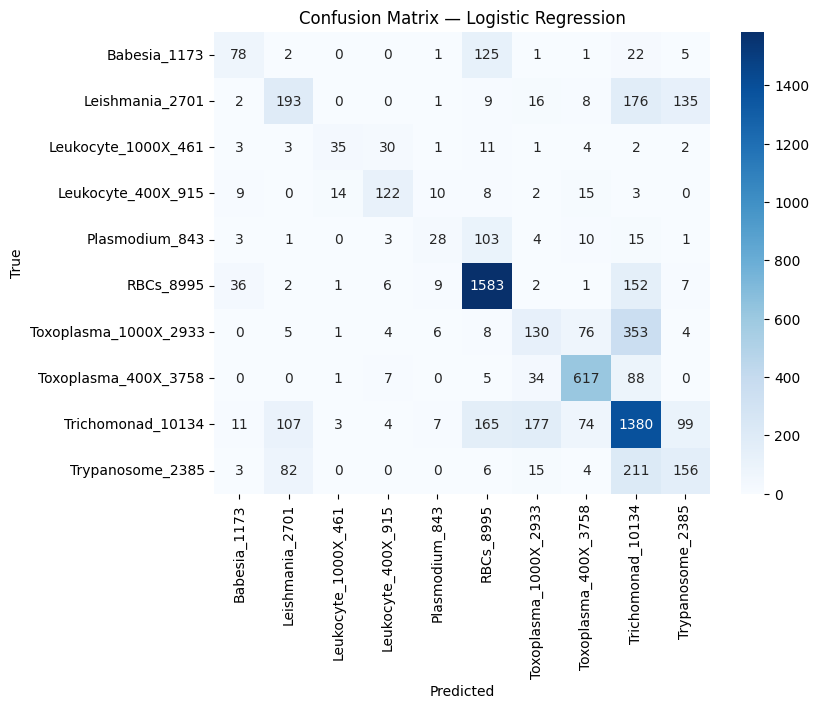

In [76]:
# 🧩 STEP 7 — Train & Evaluate Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("🚀 Training Logistic Regression model...")

# Create and train the model
clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', n_jobs=-1)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluate performance
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%\n")

# 🧾 Classification report and confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Create readable label names
# If you already have the list of class names, define it directly:
class_names = [
    "Babesia_1173",
    "Leishmania_2701",
    "Leukocyte_1000X_461",
    "Leukocyte_400X_915",
    "Plasmodium_843",
    "RBCs_8995",
    "Toxoplasma_1000X_2933",
    "Toxoplasma_400X_3758",
    "Trichomonad_10134",
    "Trypanosome_2385"
]

# Classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



<Figure size 1200x600 with 0 Axes>

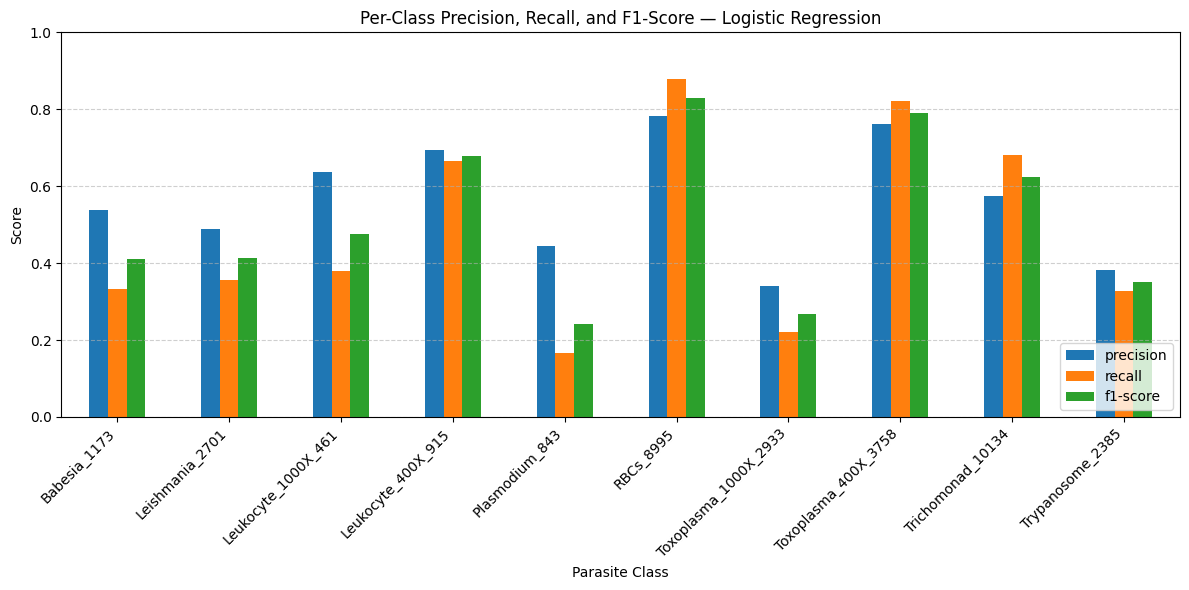

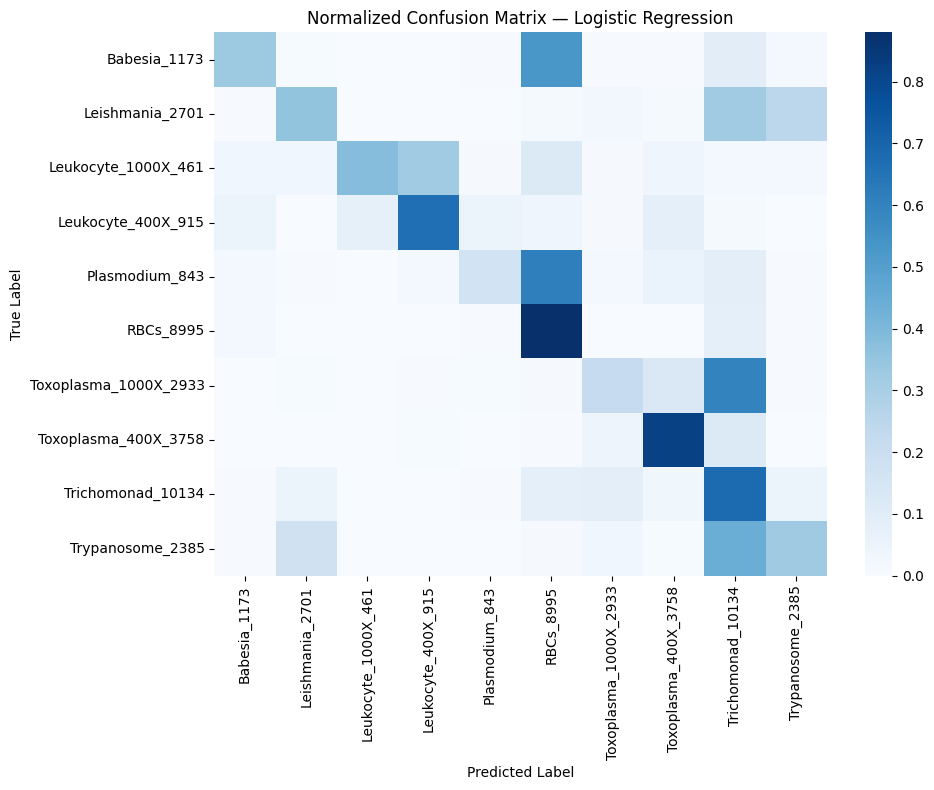


✅ Visualization complete!
Average Accuracy: 63.00%
Classes visualized: [np.str_('Babesia_1173'), np.str_('Leishmania_2701'), np.str_('Leukocyte_1000X_461'), np.str_('Leukocyte_400X_915'), np.str_('Plasmodium_843'), np.str_('RBCs_8995'), np.str_('Toxoplasma_1000X_2933'), np.str_('Toxoplasma_400X_3758'), np.str_('Trichomonad_10134'), np.str_('Trypanosome_2385')]


In [79]:
# ============================================================
# 🧩 STEP 8 — Performance Visualization (Logistic Regression)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------------
# 🧠 Recreate the label encoder (in case runtime was reset)
# ------------------------------------------------------------
label_encoder = LabelEncoder()
label_encoder.fit(y)  # 'y' should be your original label array from training

# ------------------------------------------------------------
# 📊 Generate classification report
# ------------------------------------------------------------
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# ------------------------------------------------------------
# 📈 1️⃣ Bar chart: Precision, Recall, F1-score per class
# ------------------------------------------------------------
plt.figure(figsize=(12,6))
df_report.iloc[:-3, :3].plot(kind='bar', figsize=(12,6))
plt.title("Per-Class Precision, Recall, and F1-Score — Logistic Regression")
plt.xlabel("Parasite Class")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 🧩 2️⃣ Normalized Confusion Matrix
# ------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Normalized Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 📝 Summary printout
# ------------------------------------------------------------
print("\n✅ Visualization complete!")
print("Average Accuracy: {:.2f}%".format(100 * np.mean(y_test == y_pred)))
print("Classes visualized:", list(label_encoder.classes_))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

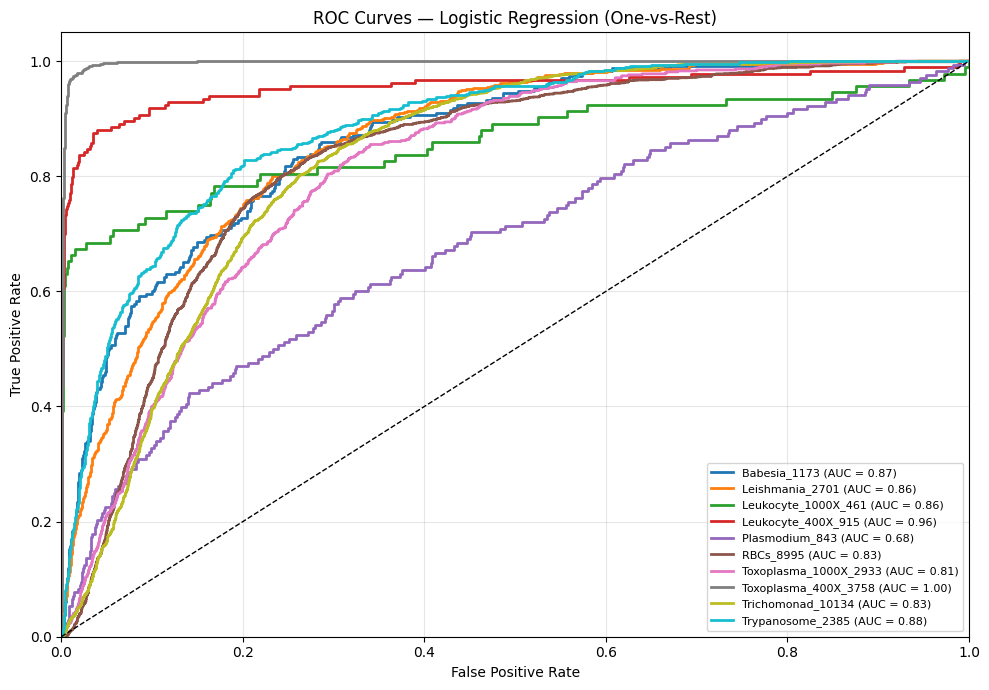

In [81]:
# ============================================================
# 🧩 ROC Curves (Fixed One-vs-Rest version for multi-class)
# ============================================================

from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

# Binarize both train and test labels using all class indices
y_train_bin = label_binarize(y_train, classes=np.arange(len(label_encoder.classes_)))
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
n_classes = y_test_bin.shape[1]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-vs-Rest Logistic Regression
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train_scaled, y_train_bin)  # ✅ Correct: fit on TRAIN data

# Decision scores for test set
y_score = clf.decision_function(X_test_scaled)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 🎨 Plot ROC Curves
plt.figure(figsize=(10,7))
colors = cycle(plt.cm.tab10.colors)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Logistic Regression (One-vs-Rest)")
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
